In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter
import sys
from numpy import arange, isscalar, asarray, array, NaN, Inf

In [2]:
Sliced_NeckTotal_1 = pickle.load( open( "Sliced_NeckTotal_1.p", "rb" ) )

In [4]:
#Defining Filter Functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [5]:
#Defining Peak Detection functions - Returns maxidx and minidx
def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
       
    if x is None:
        x = np.arange(len(v))
    
    v = np.asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

#Automated Peak Detection
def auto_peaks(data, npeaks, delta0):
    npeaks_range = [npeaks*0.9,npeaks*1.1]
    maxidx, minidx = peakdet(data,delta0,x=None) 
    
    if len(maxidx) > npeaks_range[0]:
        if len(maxidx) < npeaks_range[1]:
            return maxidx, minidx
    return auto_peaks(data,npeaks,delta0-0.02*delta0)

In [6]:
#FFT
def get_fft(sampling_rate, freq, data):
    Fs = sampling_rate
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,30,Ts) # time vector

    ff = freq;   # frequency of the signal
    y3 = data

    n = len(y3) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range

    Y = np.fft.fft(y3)/n # fft computing and normalization
    Y = Y[range(int(n/2))]
    max_abs_frq = np.where(abs(Y)==np.max(abs(Y)))
    max_abs_frq = max_abs_frq[0][0]
    return max_abs_frq

#     frq, fft_data = get_fft(fs, fft_freq, filtered_data) 

def sliding_window_fft(data, maxidx, sampling_rate, fft_freq):
    max_fft = []
    for m in maxidx:
        start_idx = m[0] - 1000
        end_idx = m[0] + 1000
        if (start_idx < 0):
            start_idx = 0
        if (end_idx >= len(data)):
            end_idx = len(data)-1
        d = data[start_idx: end_idx]
        max_fft.append(get_fft(sampling_rate, fft_freq, d))
    return max_fft

In [7]:
def fs_find(maxidx,minidx):
    
    #Finding First and Second Peaks
    first_p = []
    second_p = []
    
    for i in range(1,len(maxidx)-1):
        if i == 1:
            if (maxidx[i][0]-maxidx[i-1][0])>(maxidx[i+1][0]-maxidx[i][0]):
                second_p.append([maxidx[i-1][0], maxidx[i-1][1]])      
            else:
                first_p.append([maxidx[i-1][0], maxidx[i-1][1]])
            
           
        if (maxidx[i][0]-maxidx[i-1][0])>(maxidx[i+1][0]-maxidx[i][0]):
            if i != len(maxidx)-2:
                first_p.append([maxidx[i][0],maxidx[i][1]])
            else:
                second_p.append([maxidx[i+1][0],maxidx[i+1][1]])
          
        else:
            if i != len(maxidx)-2:
                second_p.append([maxidx[i][0],maxidx[i][1]])
            else:
                first_p.append([maxidx[i+1][0],maxidx[i+1][1]])
        
    first_t = []
    second_t = []
    
    for i in range(1,len(minidx)-1):
        if i == 1:
            if (minidx[i][0]-minidx[i-1][0])>(minidx[i+1][0]-minidx[i][0]):
                second_t.append([minidx[i-1][0], minidx[i-1][1]])      
            else:
                first_t.append([minidx[i-1][0], minidx[i-1][1]])
            
           
        if (minidx[i][0]-minidx[i-1][0])>(minidx[i+1][0]-minidx[i][0]):
            if i != len(maxidx)-2:
                first_t.append([minidx[i][0],minidx[i][1]])
            else:
                second_t.append([minidx[i+1][0],minidx[i+1][1]])
          
        else:
            if i != len(minidx)-2:
                second_t.append([minidx[i][0],minidx[i][1]])
            else:
                first_t.append([minidx[i+1][0],minidx[i+1][1]])  
    
   
             
    #Dropping outliers
    if second_p[0][0]<first_p[0][0]:
        second_p.remove(second_p[0][:])
    if first_t[0][0]<first_p[0][0]:
        first_t.remove(first_t[0][:])
    if second_t[0][0]<first_p[0][0]:
        second_t.remove(second_t[0][:])       
    fp = []
    sp = []
    ft = []
    st = []  
   
    i = 0
    p = 0
    q = 0
    r = 0
    s = 0

    while i <min(len(first_p),len(second_p),len(first_t),len(second_t)):
        
        if (p+2)>len(first_p) or (q+1)>len(first_t) or (r+1)>len(second_p) or (s+1)>len(second_t):
            break

        if second_t[s][0]<first_p[p+1][0]:
            if second_p[r][0]<first_p[p+1][0]:
                if first_t[q][0]<first_p[p+1][0]:
                    fp.append((first_p[p][0],first_p[p][1]))
                    sp.append((second_p[r][0],second_p[r][1]))
                    ft.append((first_t[q][0],first_t[q][1]))
                    st.append((second_t[s][0],second_t[s][1]))
                else:
                    p+=1
                    s+=1
                    r+=1            
            elif first_t[q][0]<first_p[p+1][0]:
                p+=1
                q+=1
                s+=1
            else: 
                p+=1
                s+=1
        else:
                         
            if second_p[r][0]<first_p[p+1][0]:
                r+=1
            if first_t[q][0]<first_p[p+1][0]:
                q+=1  
            p+=1
                
        i+=1
        p+=1
        q+=1
        r+=1
        s+=1

        
       
    return np.asarray(fp), np.asarray(sp), np.asarray(ft), np.asarray(st)        

In [8]:
def distance_between_points(arr):
    dist = []
    if (len(arr) > 1):
        i = 1
        while i < len(arr):
            d = arr[i] - arr[i-1]
            dist.append(d)
            i+=1
    return dist

In [21]:
def get_all_features(data,lowcut,highcut,order,BPM,time):

    filtered_data = butter_bandpass_filter(data, lowcut, highcut, 10240, order)
    
    
    
    npeaks = BPM*2*(time/60)
    delta0 = 2.5*np.amax(data)
 
    #peak detection
    peakdet_data = filtered_data
    maxidx, minidx = auto_peaks(peakdet_data,npeaks,delta0)
    first_peaks, second_peaks,first_troughs, second_troughs = fs_find(maxidx,minidx)
    
    if len(maxidx) > len(minidx):
        maxidx = maxidx[0:len(minidx)]
        
    elif len(maxidx) < len(minidx):
        minidx = minidx[0:len(maxidx)]
         
    #Get FFT could go here
    fft = sliding_window_fft(filtered_data, maxidx, 10240, 6)

    #first and second peak indices
    first_peaks_x = first_peaks[:,0]
    second_peaks_x = second_peaks[:,0]
    first_peaks_y = first_peaks[:,1]
    second_peaks_y = second_peaks[:,1]
    first_troughs_x = first_troughs[:,0]
    second_troughs_x = second_troughs[:,0]
    first_troughs_y = first_troughs[:,1]
    second_troughs_y = second_troughs[:,1]
     
    #distances between indices of first_peaks, second_peaks and maxidx peaks
    #Peak1amp = np.median(first_peaks_y)
    #Peak2amp = np.median(second_peaks_y)
    #Trough1amp = np.median(first_troughs_y)
    #Trough2amp = np.median(second_troughs_y)
    
    Peak1Peak1 = np.zeros(min(len(first_peaks),len(first_troughs),len(second_troughs),len(second_peaks)))
    Peak1Trough1 = np.zeros(min(len(first_peaks),len(first_troughs),len(second_troughs),len(second_peaks)))
    Peak1Trough2 = np.zeros(min(len(first_peaks),len(first_troughs),len(second_troughs),len(second_peaks)))
    Peak1Peak2 = np.zeros(min(len(first_peaks),len(first_troughs),len(second_troughs),len(second_peaks)))
    
    
    i=0
    while i < min(len(first_peaks),len(first_troughs),len(second_troughs),len(second_peaks),len(fft)):
        Peak1Peak1[i] = first_peaks_x[i]-first_peaks_x[i-1]
        Peak1Trough1[i] = first_peaks_x[i]-first_troughs_x[i]
        Peak1Trough2[i] = first_peaks_x[i]-second_troughs_x[i]
        Peak1Peak2[i] = first_peaks_x[i]-second_peaks_x[i]
        
        i+=1   
    
    #p1t1 = np.mean(Peak1Trough1)
    #p1t2 = np.mean(Peak1Trough2)
    #p1p2 = np.mean(Peak1Peak2)
    
    limit = min(len(first_peaks),len(first_troughs),len(second_troughs),len(second_peaks),len(fft))
    fft = fft[0:limit]
    first_peaks_y = first_peaks_y[0:limit]
    first_troughs_y = first_troughs_y[0:limit]
    second_peaks_y = second_peaks_y[0:limit]
    second_troughs_y = second_troughs_y[0:limit]
    
         
    return np.asarray(fft),first_peaks_y, first_troughs_y,second_peaks_y,second_troughs_y, Peak1Peak1, Peak1Trough1,Peak1Trough2,Peak1Peak2 #first_peaks,second_peaks,first_troughs,second_troughs, filtered_data

In [10]:
names = ['aravind','Balaji','Isabella','kim','Lobna','thomas','vasu']
#Stuff I want

things = []
#aravind
things.append([0,0,76800])
things.append([1,0,55000])
things.append([2,8000,31000])
things.append([3,0,45000])
things.append([4,0,76800])
#things.extend([5,0,76800])#
#things.extend([6,0,76800])#
#things.extend([7,])#
#things.extend([8,])
things.append([9,0,76800])

#Balaji
things.append([10,35000,76800])
#things.extend([1,])
#things.extend([2,])
things.append([13,0,76800])
things.append([14,0,21000])
things.append([15,10000,38000])
things.append([16,0,35000])
things.append([17,0,76800])
things.append([18,5000,76800])
things.append([19,0,55000])

#Coral
#things.extend([0,])
#things.extend([1,])
#things.extend([2,])
#things.extend([3,])
#things.extend([4,])
#things.extend([5,])
#things.extend([6,])
#things.extend([7,])
#things.extend([8,])
#things.extend([9,])

#Isabella
things.append([30,0,31000])
things.append([31,0,10000])
things.append([32,35000,76800])
things.append([33,8000,38000])
things.append([34,0,28000])
things.append([35,0,76800])
things.append([36,17000,58000])
things.append([37,0,30000])
things.append([38,0,40000])
#things.extend([39,])

#kim
things.append([40,31000,58000])
things.append([41,0,30000])
things.append([42,33000,52000])
#things.append([43,0,15000])
#things.extend([44,])
#things.append([45,63000,70000])
things.append([46,15000,76800])
#things.extend([47,])
things.append([48,42000,62000])
#things.extend([49,])

#Lobna
#things.extend([50,])
#things.extend([51,])
#things.extend([52,])
#things.extend([53,])
#things.extend([54,])
things.append([55,40000,45000])
things.append([56,25000,32000])
#things.extend([57,])
things.append([58,0,40000])
things.append([59,18000,30000])

#nathan
#things.extend([60,])
#things.extend([61,])
#things.extend([62,])
#things.extend([63,])
#things.extend([64,])
#things.extend([65,])
#things.extend([66,])
#things.extend([67,])
#things.extend([68,])
#things.extend([69,])

#thomas
things.append([70,0,72000])
things.append([71,0,72000])
things.append([72,0,76800])
things.append([73,28000,68000])
things.append([74,8000,32000])
#things.extend([75,])
#things.extend([76,])
things.append([77,0,22000])
things.append([78,0,24000])
#things.extend([79,])

#Vasu
things.append([1,0,120000])
things.append([2,0,130000])
things.append([3,0,70000])
things.append([4,60000,307200])
things.append([5,70000,210000])
things.append([16,0,180000])
things.append([17,18000,307200])
things.append([18,50000,280000])
things.append([19,50000,180000])
things.append([20,0,307200])

#anand
#things.extend([6,])
#things.extend([7,])
#things.extend([8,])
#things.extend([9,])
#things.extend([10,])
#things.extend([11,])
#things.extend([12,])
#things.extend([13,])
#things.extend([14,])
#things.extend([15,])

things = np.asarray(things)

type(things[0][0])

numpy.int64

In [28]:
#Data, Labels and Time
Data = []
Y_mean = np.zeros(len(things))
time = []
c = 0
for i in range(len(things)-10):
    Data.append(Sliced_NeckTotal_1[things[i][0]][things[i][1]:things[i][2]])
    Y_mean[i] = c
    if int(things[i+1][0]/10)!= int(things[i][0]/10):
        c+=1
    time.append((30/76800)*(things[i][2]-things[i][1]))
    
     
    
for i in range(len(things)-10,len(things)):
    Data.append(get_neck_data(things[i][0])[things[i][1]:things[i][2]])
    Y_mean[i] = 6
    time.append((30/307200)*(things[i][2]-things[i][1]))

In [12]:
#BPMS:
BPMold = [75,75,76,78,75,76,75,80,80,78] #Aravind 
BPMold.extend([85,80,77,80,81,82,84,80,83,86]) #Balaji
BPMold.extend([0,0,0,0,0,0,0,0,0,0])#Coral
BPMold.extend([73,74,74,73,74,73,72,85,94,92]) #Isabella
BPMold.extend([60,57,57,60,60,65,62,62,60,59]) #Kim
BPMold.extend([74,74,80,78,85,86,82,82,86,84]) #Lobna
BPMold.extend([0,0,0,0,0,0,0,0,0,0])#Nathan
BPMold.extend([62,68,61,66,64,65,67,65,66,67]) #Thomas
BPMold.extend([64,64,64,64,64,64,64,64,64,64]) #Vasu

BPMold = np.asarray(BPMold)
BPM = np.zeros(len(things))

for i in range(len(things)-10):
    BPM[i] = BPMold[things[i][0]]
    
for i in range(len(things)-10,len(things)):
    BPM[i] = 64

In [24]:
#INPUT - get_all_features(data,lowcut,highcut,order,BPM,time):
#OUTPUT (8) - fft,first_peaks_y, first_troughs_y,second_peaks_y,second_troughs_y, Peak1Trough1,Peak1Trough2,Peak1Peak2,first_peaks,second_peaks,first_troughs,second_troughs
X =[]
Y = []
X_mean = np.zeros((len(things),9))
X_median = np.zeros((len(things),9))

for i in range(len(Data)):
    
    
    print (i)
    a,b,c,d,e,f,g,h,j = get_all_features(Data[i],10,90,2,BPM[i],time[i])
    
    limit = min(len(a),len(b),len(c),len(d),len(e),len(f),len(g),len(h),len(j))
    
    for item in range(limit):
        X.append([a[item],b[item],c[item],d[item],e[item],f[item],g[item],h[item],j[item]])
        Y.append(Y_mean[i])
 
    
    X_mean[i][0]=np.mean(a)
    X_median[i][0] = np.median(a)
    X_mean[i][1]=np.mean(b)
    X_median[i][1] = np.median(b)
    X_mean[i][2]=np.mean(c)
    X_median[i][2] = np.median(c)
    X_mean[i][3]=np.mean(d)
    X_median[i][3] = np.median(d)
    X_mean[i][4]=np.mean(e)
    X_median[i][4] = np.median(e)
    X_mean[i][5]=np.mean(f)
    X_median[i][5] = np.median(f)
    X_mean[i][6]=np.mean(g)
    X_median[i][6] = np.median(g)
    X_mean[i][7]=np.mean(h)
    X_median[i][7] = np.median(h)
    X_mean[i][8]=np.mean(j)
    X_median[i][8] = np.median(j)

print ('Done')

0


/Users/haileykim/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
Done


In [30]:
pickle.dump(X, open( "X_Neck.p", "wb" ))
pickle.dump(Y, open( "Y_Neck.p", "wb" ))
pickle.dump(X_median, open( "X_median_Neck.p", "wb" ))
pickle.dump(Y_median, open( "Y_median_Neck.p", "wb" ))
pickle.dump(X_mean, open( "X_mean_Neck.p", "wb" ))
pickle.dump(Y_mean, open( "Y_mean_Neck.p", "wb" ))

In [439]:
from sklearn import tree
from sklearn.cross_validation import cross_val_score


In [ ]:
clf = []
scoresall = []
for i in range(1,1000):
    for j in range(2,100):
        clf.append(tree.DecisionTreeClassifier(max_depth = i))
        clf[i-1] = clf[i-1].fit(X, Y)
        scoresall.append(cross_val_score(clf[i-1], X, Y, cv = j))


C:\Users\SUCESS\Anaconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 21 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=22.
  % (min_labels, self.n_folds)), Warning)
C:\Users\SUCESS\Anaconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 21 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=23.
  % (min_labels, self.n_folds)), Warning)
C:\Users\SUCESS\Anaconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 21 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=24.
  % (min_labels, self.n_folds)), Warning)
C:\Users\SUCESS\Anaconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 21 members, which is too few. The minimum number of lab

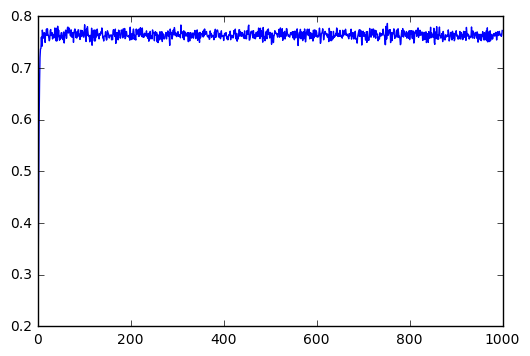

In [455]:
scores = np.zeros(999)
for i in range(len(scoresall)):
    scores[i] = np.mean(scoresall[i])
#print(np.asarray(scores).shape)    
plt.plot(range(1,1000),scores)

In [33]:
a,b,c,d,e,f,g,h,fp,ft,sp,st,dat = get_all_features(Data[40],10,90,2,BPM[40],time[40])



C:\Users\SUCESS\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


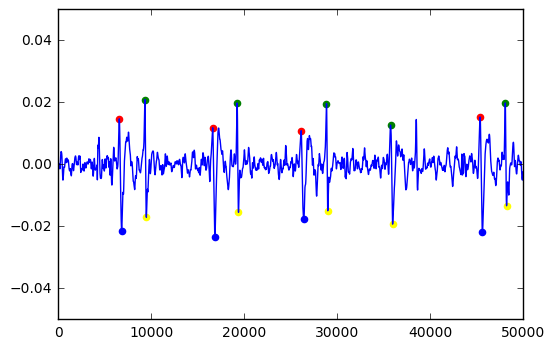

In [52]:
plt.figure()
plt.plot(dat)
plt.scatter(fp[:,0],fp[:,1],color = 'red')
plt.scatter(sp[:,0],sp[:,1],color = 'blue')
plt.scatter(ft[:,0],ft[:,1],color = 'green')
plt.scatter(st[:,0],st[:,1],color = 'yellow')
plt.xlim([0,50000])
plt.ylim([-0.05,0.05])
plt.show()

In [50]:
st[5][1]

-0.014227291766078058